In [2]:
from pathlib import Path
import time
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

exec(open("../functions.py").read())

In [7]:
# set basic parameters and subdirectory
part_n = 500
e_part_r = 0.8
e_mean = 0
ei_std_s = [4, 4]
waiting_time = 300
interval_len = 1300
freq = 0.1
subdirectory = ("{:n}_".format(part_n)
                + "{:n}_".format(e_part_r)
                + "{:n}_".format(e_mean)
                + "{0:n}-{1:n}/".format(ei_std_s[0],
                                        ei_std_s[1]))
#Path(subdirectory).mkdir()
print(ei_spectral_radius_fct(e_part_r, ei_std_s))

seed = 1701297462#round(time.time())
subdirectory = (subdirectory + "{:n}_".format(seed)
                + "{0:n}-{1:n}_".format(interval_len, 
                                        waiting_time)
                + "{:n}/".format(freq))
#Path(subdirectory).mkdir()
print(subdirectory)

4.0
500_0.8_0_4-4/1701297462_1300-300_0.1/


In [11]:
# generate and save parameters for simulation
key = jax.random.PRNGKey(seed)

sub_part_r_s = jnp.asarray([e_part_r, 1 - e_part_r])
sub_part_n_s = sub_part_n_s_fct(part_n, sub_part_r_s)
unscaled_mean = ei_mean_balancer(sub_part_r_s, e_mean)
unscaled_std = jnp.tile(jnp.asarray([ei_std_s]), (2, 1))
connectivity_n = 5
in_r = 1.
rewiring_prob = 1.
[connectivity_s, key] = row_sum_removing_sparsifier(connectivity_s_generator(sub_part_n_s,
                                                                             unscaled_mean, unscaled_std,
                                                                             connectivity_n,
                                                                             key),
                                                    sub_part_n_s, in_r, rewiring_prob)

sub_part_n_s_ext_gen = jnp.asarray([part_n])
ext_part_n = part_n // 100
ext_sub_part_r_s = jnp.asarray([1.])
ext_sub_part_n_s = sub_part_n_s_fct(ext_part_n, ext_sub_part_r_s)
unscaled_ext_mean = jnp.asarray([[0.]])
unscaled_ext_std = jnp.asarray([[1.]])
ext_connectivity_n = 3
[ext_connectivity_s, key] = ext_connectivity_s_generator(sub_part_n_s_ext_gen, ext_sub_part_n_s,
                                                         unscaled_ext_mean, unscaled_ext_std,
                                                         ext_connectivity_n,
                                                         key)

phase_n = 3
[phase_s, key] = phase_s_generator(ext_part_n, phase_n, key)

amp_s = jnp.expand_dims(jnp.asarray([0.2, 0.5, 1., 8., 12.]), 
                        # or (wave_n, ext_part_n) array so different ext parts have different amps
                        1)
freq_s = jnp.full(amp_s.shape, freq)
wave_s = jnp.concatenate([amp_s, freq_s], axis = 1)
wave_n = wave_s.shape[0]

init_condition_n = 5
ext_condition_n = ext_connectivity_n * phase_n
init_condition_n_free = init_condition_n * ext_condition_n
[init_condition_s, key] = init_condition_s_generator(part_n, 
                                                           jnp.full((part_n, ), 0), jnp.identity(part_n), 
                                                           init_condition_n_free, key)

label_s = jnp.asarray([1])
label_s_free = jnp.asarray([0])
time_interval_s = jnp.asarray([[0, interval_len]])
window_len_s = jnp.asarray([10, 20, 40, 80, 160, 320]) # used length = 1000
labeled_time_interval_s = [time_interval_s, label_s]
labeled_time_interval_s_free = [time_interval_s, label_s_free]

resolution = 24

condition_n_s = jnp.asarray([connectivity_n, wave_n, ext_connectivity_n, phase_n,
                             init_condition_n])
condition_n_s_free = jnp.asarray([connectivity_n, 1, 1, 1,
                                  init_condition_n_free])

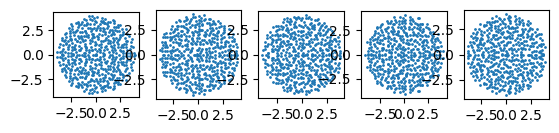

In [12]:
# plot spectra
[fig, subfig_s] = plt.subplots(1, int(connectivity_n), squeeze = False)
for connectivity_idx in range(connectivity_n):
  temp_spectrum = jnp.linalg.eig(connectivity_s[connectivity_idx])[0]
  subfig_s[0, connectivity_idx].plot(jnp.real(temp_spectrum), jnp.imag(temp_spectrum),
                                  linestyle="", marker=".", markersize = 2)
  subfig_s[0, connectivity_idx].set_aspect('equal')

In [13]:
def multi_len_pr_tr_os_s_initializer(condition_n_s, window_len_s,
                                     samp_n):
  window_len_n = window_len_s.shape[0]
  return([jnp.zeros(tuple(condition_n_s)
                    + (window_len_n + 1, samp_n))
          for stat_idx in range(4)])

def multi_len_pr_tr_os_s_fct(traj, resolution,
                             kernel_s, samp_sep_with_n):
  # find numbers
  # <explicit convolution prep>
  part_n = traj.shape[0]
  # </explicit convolution prep>
  # # <fourier convolution prep>
  # frame_n = traj.shape[1]
  # # </fourier convolution prep>
  kernel_frame_n = kernel_s.shape[-1]
  window_len_n = kernel_s.shape[0]
  [samp_sep, samp_n] = samp_sep_with_n
  # find reference values (window at full length)
  full_mean = mean_s_fct(traj)
  full_cov = cov_s_fct(traj, full_mean)
  full_pc = es_s_fct(full_cov)
  full_pr = dim_r_s_fct(full_pc[0])
  full_tr = size_s_fct(full_pc[0])
  # find fluctuations first then prepare for convolution (global mean used)
  fluct = traj - jnp.expand_dims(full_mean, -1)
  # <explicit convolution prep>
  temp_segmented_fluct_s = jax.lax.fori_loop(
    0, samp_n,
    lambda samp_idx, windowed_fluct_s:
    windowed_fluct_s.at[
      samp_idx].set(
        jax.lax.dynamic_slice(fluct,
                              (0, samp_idx * samp_sep),
                              (part_n, kernel_frame_n))),
    jnp.zeros((samp_n, part_n, kernel_frame_n)))
  # </explicit convolution prep>
  # # <fourier convolution prep>
  # cross_fluct_ft = jnp.fft.rfft(
  #   jnp.expand_dims(fluct, -2) * jnp.expand_dims(fluct, -3))
  # # </fourier convolution prep>
  # initialize output
  multi_len_pr_tr_os_s = [
    jnp.zeros((window_len_n + 1, samp_n)).at[-1].set(full_pr),
    jnp.zeros((window_len_n + 1, samp_n)).at[-1].set(full_tr),
    jnp.zeros((window_len_n + 1, samp_n)).at[-1].set(1),
    jnp.zeros((window_len_n + 1, samp_n)).at[-1].set(1)]
  def single_len_pr_tr_os_updater(window_len_idx, multi_len_pr_tr_os_s):
    # <explicit convolution>
    temp_cov_s = weighted_cov_s_fct(temp_segmented_fluct_s,
                                    jnp.zeros((part_n, )),
                                    kernel_s[window_len_idx])
    # </explicit convolution>
    # # <fourier convolution>
    # temp_kernel_ft = jnp.fft.rfft(kernel_s[window_len_idx], frame_n)
    # temp_cov_s = jnp.swapaxes(
    #   jnp.fft.irfft(
    #     cross_fluct_ft * temp_kernel_ft, frame_n)[
    #       ..., (kernel_frame_n - 1)::samp_sep][
    #       ..., :samp_n],
    #   -3, -1)
    # # </fourier convolution>
    temp_pc_s = es_s_fct(temp_cov_s)
    temp_pr_s = dim_r_s_fct(temp_pc_s[0])
    temp_tr_s = size_s_fct(temp_pc_s[0])
    temp_os_s = ori_similarity_s_fct(full_pc, temp_pc_s,
                                     full_tr, temp_tr_s)
    temp_lagged_os_s = ori_similarity_s_fct([temp_pc_s[0][0], temp_pc_s[1][0]], temp_pc_s,
                                            temp_tr_s[0], temp_tr_s)
    multi_len_pr_tr_os_s = [
      multi_len_pr_tr_os_s[0].at[window_len_idx].set(temp_pr_s),
      multi_len_pr_tr_os_s[1].at[window_len_idx].set(temp_tr_s),
      multi_len_pr_tr_os_s[2].at[window_len_idx].set(temp_os_s),
      multi_len_pr_tr_os_s[3].at[window_len_idx].set(temp_lagged_os_s)]
    return(multi_len_pr_tr_os_s)
  multi_len_pr_tr_os_s = jax.lax.fori_loop(0, window_len_n,
                                           single_len_pr_tr_os_updater,
                                           multi_len_pr_tr_os_s)
  return(multi_len_pr_tr_os_s)
multi_len_pr_tr_os_s_fct = jax.jit(multi_len_pr_tr_os_s_fct,
                                   static_argnums = (3, ))


In [14]:
kernel_power = 2#jnp.inf
max_kernel_fraction = 0.4#0.96

samp_sep_with_n = samp_sep_with_n_fct(window_len_s, resolution)
kernel_s = kernel_s_fct(window_len_s, resolution, kernel_power, max_kernel_fraction)

# initialize and run stats

def short_multi_len_pr_tr_os_s_fct(traj):
  return(multi_len_pr_tr_os_s_fct(traj[..., (waiting_time * resolution):], resolution,
                                  kernel_s, samp_sep_with_n))

start_time = time.time()

stat_s_free = multi_len_pr_tr_os_s_initializer(condition_n_s_free, window_len_s, samp_sep_with_n[1])
stat_s_free = stat_s_fct(connectivity_s, wave_s[:1], ext_connectivity_s[:1], phase_s[:1], init_condition_s,
                         labeled_time_interval_s_free, resolution,
                         short_multi_len_pr_tr_os_s_fct, stat_s_free)
np.savez_compressed(subdirectory + "stats_free.npz", *stat_s_free) # jax has not implemented savez_compressed as of 23/08/23

# stat_s = multi_len_pr_tr_os_s_initializer(condition_n_s, window_len_s, samp_sep_with_n[1])
# stat_s = stat_s_fct(connectivity_s, wave_s, ext_connectivity_s, phase_s, init_condition_s[::ext_condition_n],
#                     labeled_time_interval_s, resolution, 
#                     short_multi_len_pr_tr_os_s_fct, stat_s)
# np.savez_compressed(subdirectory + "stats.npz", *stat_s)

end_time = time.time()
print("took {:.2f} mins".format((end_time - start_time) / 60))

[5, 'connectivity_n']
[1, 'wave_n']
[1, 'ext_connectivity_n']
[1, 'phase_n']
[45, 'init_condition_n']
4 stats
expecting 44.25 mins
took 45.39 mins


In [19]:
# load trajs
stat_s_free = load_as_list(subdirectory + "stats_free.npz")
# stat_s = load_as_list(subdirectory + "stats.npz")

In [20]:
#export free pr
np.savez_compressed(subdirectory + "../../../predic_free.npz", 
                    jnp.append(window_len_s, interval_len - waiting_time), 
                    jnp.arange(samp_sep_with_n[1]) * samp_sep_with_n[0] / resolution, 
                    *stat_s_free)

plotting

In [ ]:
[pr_s_free, tr_s_free, os_s_free] = stat_s_free
[pr_s, tr_s, os_s] = stat_s

In [ ]:
#making sure nothing is strange from the trs
[fig, subfig_s] = plt.subplots(wave_n + 1, 1, figsize = (9, 5))
subfig_s[0].plot(tr_s_free[..., -1].flatten(), label = 0., 
                 marker='.', linestyle='')
for wave_idx in range(wave_n):
  subfig_s[wave_idx + 1].plot(tr_s[:, wave_idx, ..., -1].flatten(), label = amp_s[wave_idx, 0],
                              marker='.', linestyle='')
plt.setp(subfig_s, ylim=(0,1))

In [ ]:
def temp_val_fct(stat_s_wrt_amp_s):
  return([jnp.concatenate([fct(stat_s, axis = (0,2,3,4, 6))
                           for stat_s in stat_s_wrt_amp_s], axis = 0)
          for fct in [jnp.mean, jnp.std]])

def temp_r_fct(stat_s_wrt_amp_s):
  return([jnp.concatenate([fct(stat_s / stat_s[...,-1:,:], axis = (0,2,3,4, 6))
                           for stat_s in stat_s_wrt_amp_s], axis = 0)
          for fct in [jnp.mean, jnp.std]])

val_r_stat_s = [[temp_val_fct([pr_s_free, pr_s]), 
                 temp_val_fct([tr_s_free, tr_s]), 
                 temp_val_fct([os_s_free, os_s])],
                [temp_r_fct([pr_s_free, pr_s]), 
                 temp_r_fct([tr_s_free, tr_s]), 
                 temp_r_fct([os_s_free, os_s])]]

plot_amp_s = jnp.insert(amp_s, 0, 0)
plot_window_len_s = jnp.append(window_len_s, interval_len - waiting_time)
[fig, subfig_s] = plt.subplots(2, 3, figsize = (20,12))
for val_or_r in range(2):
  subfig_s[val_or_r,0].title.set_text("pr")
  subfig_s[val_or_r,1].title.set_text("tr")
  subfig_s[val_or_r,2].title.set_text("os")
  for stat_idx in range(3):
    for amp_idx in range(wave_n + 1):
      subfig_s[val_or_r,stat_idx].errorbar(plot_window_len_s,
                           val_r_stat_s[val_or_r][stat_idx][0][amp_idx],
                           yerr = val_r_stat_s[val_or_r][stat_idx][1][amp_idx],
                           capsize = 2, label = str(plot_amp_s[amp_idx]))
    subfig_s[val_or_r,stat_idx].set_xscale("log")
    subfig_s[val_or_r,stat_idx].set_xticks(plot_window_len_s, labels = plot_window_len_s)
    subfig_s[val_or_r,stat_idx].legend()
    subfig_s[val_or_r,stat_idx].grid()

n=500

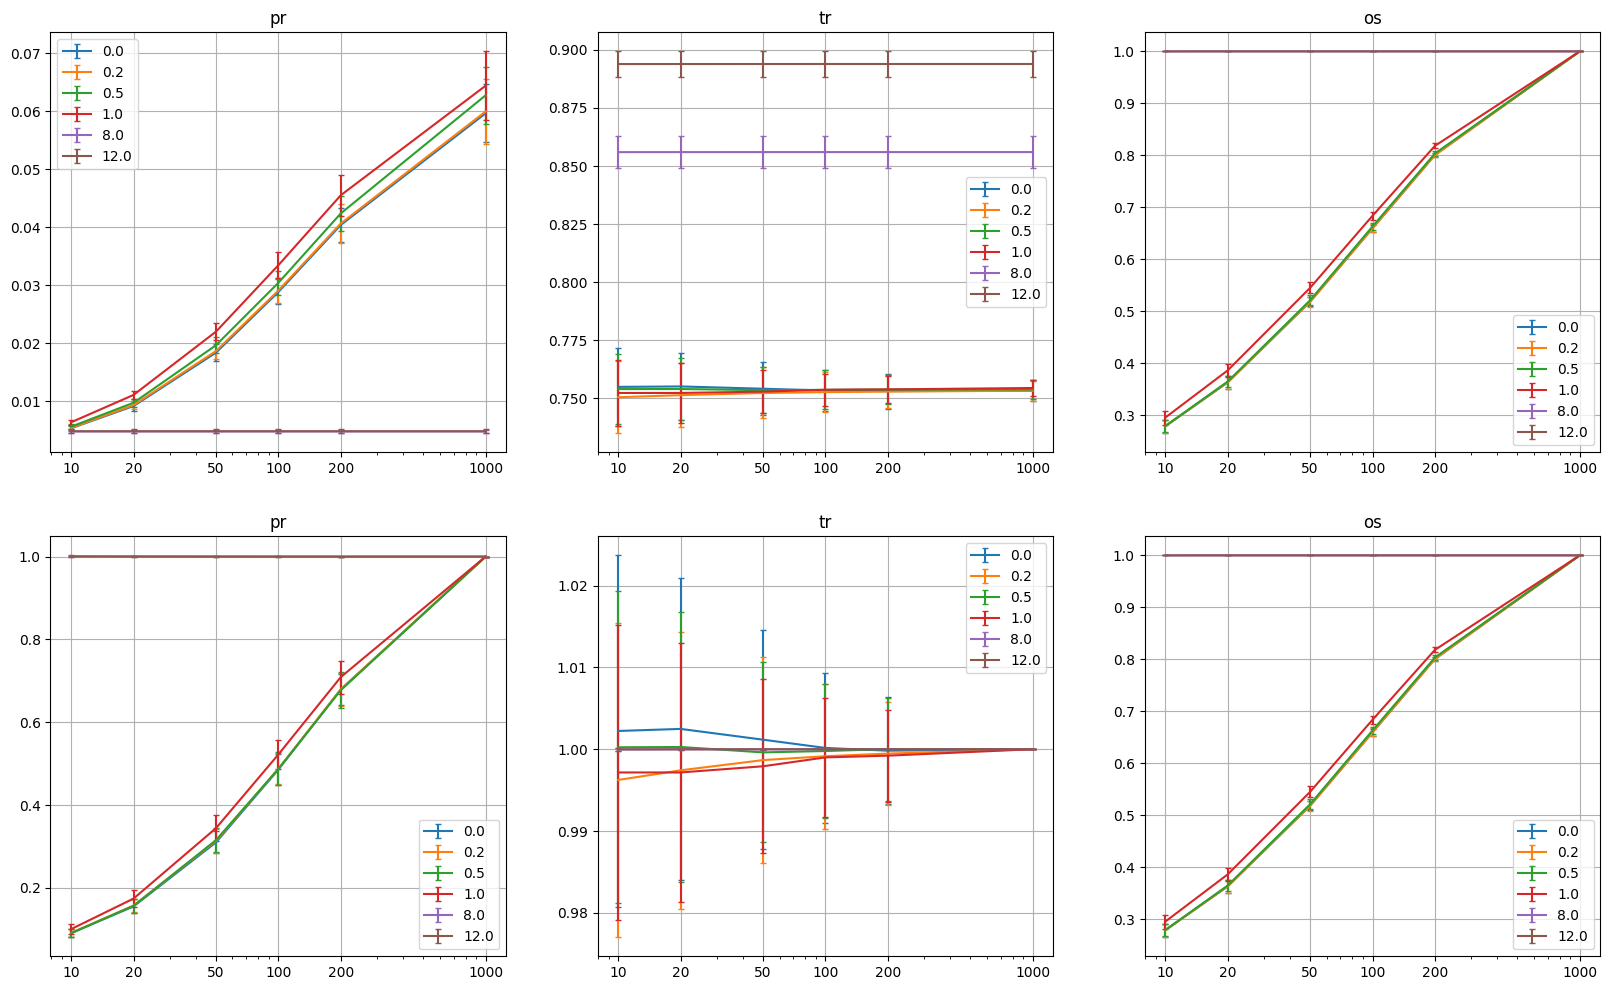

In [12]:
def temp_val_fct(stat_s_wrt_amp_s):
  return([jnp.concatenate([fct(stat_s, axis = (0,2,3,4))
                           for stat_s in stat_s_wrt_amp_s], axis = 0)
          for fct in [jnp.mean, jnp.std]])

def temp_r_fct(stat_s_wrt_amp_s):
  return([jnp.concatenate([fct(stat_s / stat_s[...,-1:], axis = (0,2,3,4))
                           for stat_s in stat_s_wrt_amp_s], axis = 0)
          for fct in [jnp.mean, jnp.std]])

val_r_stat_s = [[temp_val_fct([pr_s_free, pr_s]), 
                 temp_val_fct([tr_s_free, tr_s]), 
                 temp_val_fct([os_s_free, os_s])],
                [temp_r_fct([pr_s_free, pr_s]), 
                 temp_r_fct([tr_s_free, tr_s]), 
                 temp_r_fct([os_s_free, os_s])]]

plot_amp_s = jnp.insert(amp_s, 0, 0)
plot_window_len_s = jnp.append(window_len_s, interval_len - waiting_time)
[fig, subfig_s] = plt.subplots(2, 3, figsize = (20,12))
for val_or_r in range(2):
  subfig_s[val_or_r,0].title.set_text("pr")
  subfig_s[val_or_r,1].title.set_text("tr")
  subfig_s[val_or_r,2].title.set_text("os")
  for stat_idx in range(3):
    for amp_idx in range(wave_n + 1):
      subfig_s[val_or_r,stat_idx].errorbar(plot_window_len_s,
                           val_r_stat_s[val_or_r][stat_idx][0][amp_idx],
                           yerr = val_r_stat_s[val_or_r][stat_idx][1][amp_idx],
                           capsize = 2, label = str(plot_amp_s[amp_idx]))
    subfig_s[val_or_r,stat_idx].set_xscale("log")
    subfig_s[val_or_r,stat_idx].set_xticks(plot_window_len_s, labels = plot_window_len_s)
    subfig_s[val_or_r,stat_idx].legend()
    subfig_s[val_or_r,stat_idx].grid()